In [1]:
# Import relevant libraries and packages
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from scipy import stats
from math import radians, cos, sin, asin, sqrt

In [3]:
# Configure matplotlib for better plots
plt.rcParams.update({
    "font.family": "serif",
    "figure.figsize": (12, 8),
    "axes.grid": True,
    "grid.alpha": 0.3
})

In [4]:
# Set some display options for pandas
pd.set_option('display.max_columns', 50)

In [5]:
# Path to the database
DB_PATH = "data/cta_database.db"

In [6]:
# Connect to SQLite database
conn = sqlite3.connect(DB_PATH)

In [7]:
# SQL query to select all data from the table
query = "SELECT * FROM train_positions"

In [8]:
# Load the data into a Pandas DataFrame
df = pd.read_sql_query(query, conn)

In [9]:
# Close the connection
conn.close()

## Data Overview & Quality Assessment

In [10]:
# --- Initial Inspection ---
print(f"Shape of the dataset: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())
print("\nData Info:")
df.info()

# Basic statistics
print("\nDataset Summary:")
print(f"Total records: {len(df):,}")
print(f"Date range: {pd.to_datetime(df['fetch_timestamp'], unit='s').min()} to {pd.to_datetime(df['fetch_timestamp'], unit='s').max()}")
print(f"Unique routes: {df['route_name'].nunique()}")
print(f"Unique trains: {df['run_number'].nunique()}")
print(f"Records with delays: {df['is_delayed'].sum():,} ({df['is_delayed'].mean():.1%})")

# Route distribution
print("\nRecords by route:")
print(df['route_name'].value_counts())

Shape of the dataset: (918, 11)

First 5 rows:


,id,fetch_timestamp,run_number,route_name,destination_name,next_station_name,arrival_time,is_delayed,latitude,longitude,heading
0,1,1756752760,803,red,Howard,Argyle,1756727567,0,41.96914,-87.65849,0
1,2,1756752760,804,red,Howard,Sheridan,1756727579,0,41.95377,-87.65493,271
2,3,1756752760,805,red,Howard,Fullerton,1756727702,0,41.91065,-87.64918,305
3,4,1756752760,806,red,Howard,Clark/Division,1756727594,0,41.90394,-87.62893,273
4,5,1756752760,808,red,Howard,79th,1756727596,0,41.74410,-87.62499,358



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 918 non-null    int64  
 1   fetch_timestamp    918 non-null    int64  
 2   run_number         918 non-null    object 
 3   route_name         918 non-null    object 
 4   destination_name   918 non-null    object 
 5   next_station_name  918 non-null    object 
 6   arrival_time       918 non-null    int64  
 7   is_delayed         918 non-null    int64  
 8   latitude           918 non-null    float64
 9   longitude          918 non-null    float64
 10  heading            918 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 79.0+ KB

Dataset Summary:
Total records: 918
Date range: 2025-09-01 18:52:40 to 2025-09-01 19:05:19
Unique routes: 8
Unique trains: 86
Records with delays: 2 (0.2%)

Records by route:
route_name
blue    2

## Feature Engineering for Anomaly Detection

In [11]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between two points on earth (in km)"""
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Sort by train and timestamp for speed calculation
df_sorted = df.sort_values(['run_number', 'fetch_timestamp']).copy()

# Calculate speed for each train
df_sorted['prev_lat'] = df_sorted.groupby('run_number')['latitude'].shift(1)
df_sorted['prev_lon'] = df_sorted.groupby('run_number')['longitude'].shift(1)
df_sorted['prev_timestamp'] = df_sorted.groupby('run_number')['fetch_timestamp'].shift(1)

# Calculate distance and time differences
mask = df_sorted[['prev_lat', 'prev_lon', 'prev_timestamp']].notna().all(axis=1)
df_sorted.loc[mask, 'distance_km'] = df_sorted.loc[mask].apply(
    lambda row: haversine_distance(row['prev_lat'], row['prev_lon'], row['latitude'], row['longitude']), 
    axis=1
)
df_sorted.loc[mask, 'time_diff_hours'] = (df_sorted.loc[mask, 'fetch_timestamp'] - df_sorted.loc[mask, 'prev_timestamp']) / 3600

# Calculate speed (km/h), handle division by zero
df_sorted.loc[mask, 'speed_kmh'] = df_sorted.loc[mask, 'distance_km'] / df_sorted.loc[mask, 'time_diff_hours']
df_sorted.loc[df_sorted['time_diff_hours'] == 0, 'speed_kmh'] = 0

# Add time-based features
df_sorted['datetime'] = pd.to_datetime(df_sorted['fetch_timestamp'], unit='s')
df_sorted['hour_of_day'] = df_sorted['datetime'].dt.hour
df_sorted['day_of_week'] = df_sorted['datetime'].dt.dayofweek
df_sorted['is_weekend'] = df_sorted['day_of_week'].isin([5, 6])
df_sorted['is_rush_hour'] = df_sorted['hour_of_day'].isin([7, 8, 9, 17, 18, 19])

print(f"Speed calculation complete. Records with speed data: {df_sorted['speed_kmh'].notna().sum():,}")
print(f"Speed statistics (km/h):")
print(df_sorted['speed_kmh'].describe())

Speed calculation complete. Records with speed data: 832
Speed statistics (km/h):
count    832.000000
mean      34.282902
std       31.711712
min        0.000000
25%       16.999976
50%       27.735707
75%       43.668816
max      314.539540
Name: speed_kmh, dtype: float64


## Temporal Patterns Analysis

/var/folders/71/0hnjxlbj1k93ry1fd_9c57200000gn/T/ipykernel_70758/2375664385.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot(route_speeds, labels=df_sorted['route_name'].unique())


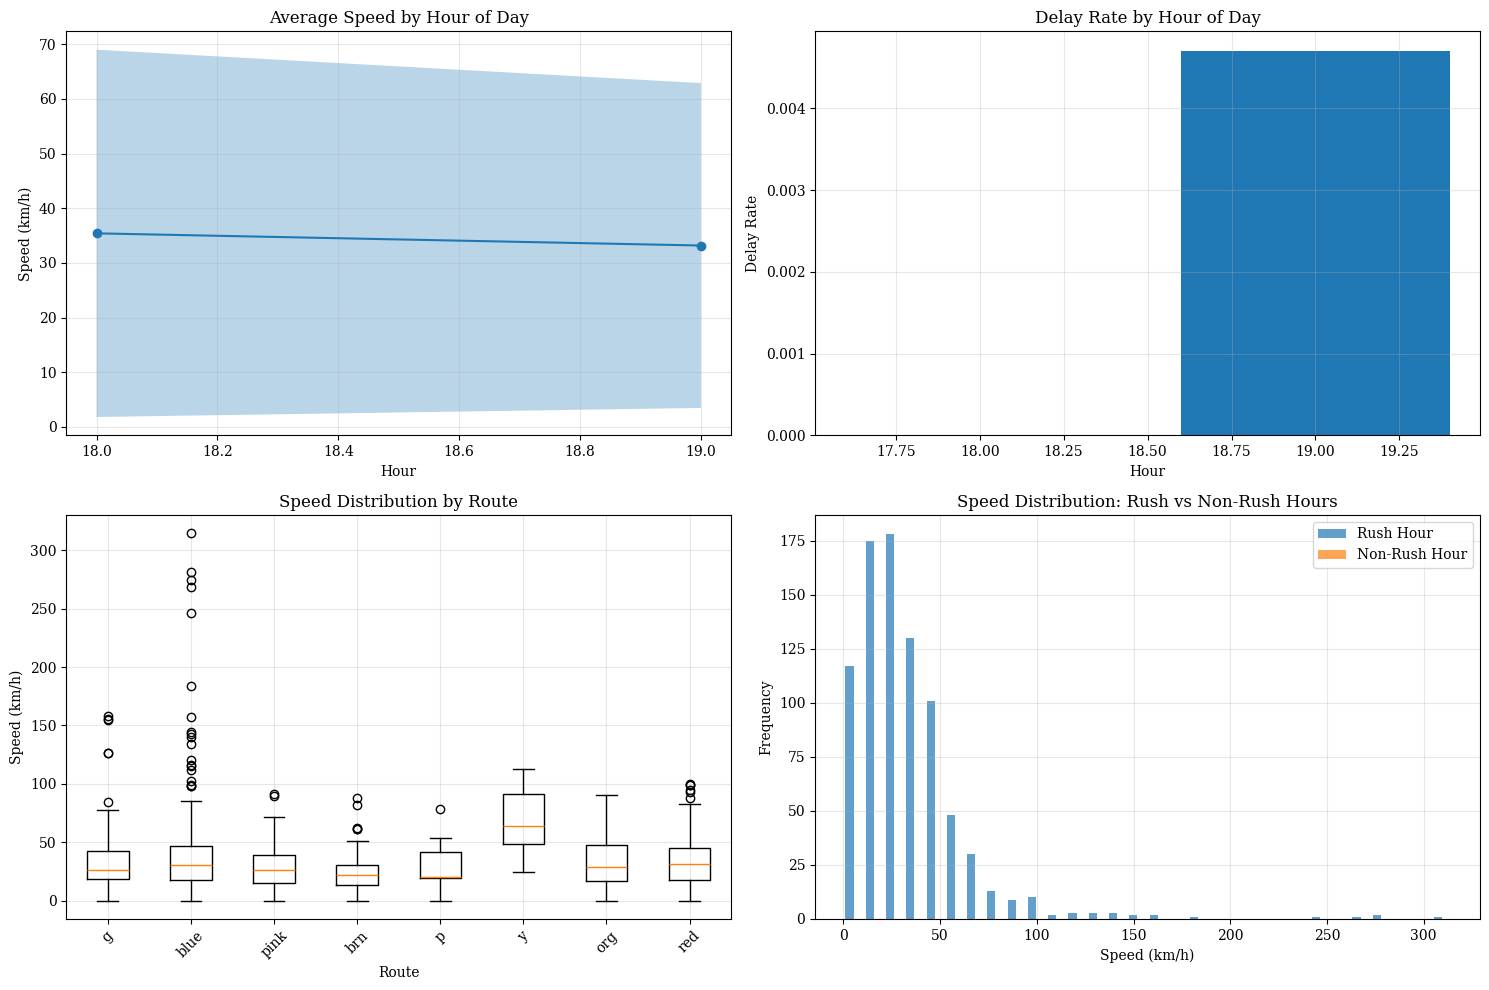

In [12]:
# Create subplots for temporal analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Speed by hour of day
hourly_speed = df_sorted.groupby('hour_of_day')['speed_kmh'].agg(['mean', 'std']).reset_index()
axes[0,0].plot(hourly_speed['hour_of_day'], hourly_speed['mean'], marker='o')
axes[0,0].fill_between(hourly_speed['hour_of_day'], 
                       hourly_speed['mean'] - hourly_speed['std'],
                       hourly_speed['mean'] + hourly_speed['std'], alpha=0.3)
axes[0,0].set_title('Average Speed by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Speed (km/h)')

# Delay rate by hour
hourly_delays = df_sorted.groupby('hour_of_day')['is_delayed'].mean()
axes[0,1].bar(hourly_delays.index, hourly_delays.values)
axes[0,1].set_title('Delay Rate by Hour of Day')
axes[0,1].set_xlabel('Hour')
axes[0,1].set_ylabel('Delay Rate')

# Speed distribution by route
route_speeds = [df_sorted[df_sorted['route_name'] == route]['speed_kmh'].dropna() 
                for route in df_sorted['route_name'].unique()]
axes[1,0].boxplot(route_speeds, labels=df_sorted['route_name'].unique())
axes[1,0].set_title('Speed Distribution by Route')
axes[1,0].set_xlabel('Route')
axes[1,0].set_ylabel('Speed (km/h)')
axes[1,0].tick_params(axis='x', rotation=45)

# Rush hour vs non-rush hour speeds
rush_speeds = df_sorted[df_sorted['is_rush_hour']]['speed_kmh'].dropna()
non_rush_speeds = df_sorted[~df_sorted['is_rush_hour']]['speed_kmh'].dropna()
axes[1,1].hist([rush_speeds, non_rush_speeds], bins=30, alpha=0.7, 
               label=['Rush Hour', 'Non-Rush Hour'])
axes[1,1].set_title('Speed Distribution: Rush vs Non-Rush Hours')
axes[1,1].set_xlabel('Speed (km/h)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## Baseline Anomaly Detection (Z-Score Method)

In [13]:
# Context-aware Z-score anomaly detection
def detect_speed_anomalies(group, threshold=2.5):
    """Detect anomalies within a group using Z-score"""
    if len(group) < 3:  # Need minimum samples
        return pd.Series([False] * len(group), index=group.index)
    
    z_scores = np.abs(stats.zscore(group['speed_kmh'].fillna(group['speed_kmh'].median())))
    return z_scores > threshold

# Apply anomaly detection grouped by route and hour
df_sorted['is_speed_anomaly'] = df_sorted.groupby(['route_name', 'hour_of_day']).apply(
    detect_speed_anomalies
).reset_index(level=[0,1], drop=True)

# Summary of anomalies
anomaly_count = df_sorted['is_speed_anomaly'].sum()
anomaly_rate = df_sorted['is_speed_anomaly'].mean()

print(f"Baseline Anomaly Detection Results:")
print(f"Total anomalies detected: {anomaly_count:,}")
print(f"Anomaly rate: {anomaly_rate:.2%}")
print(f"\nAnomalies by route:")
print(df_sorted.groupby('route_name')['is_speed_anomaly'].agg(['sum', 'mean']).round(3))

Baseline Anomaly Detection Results:
Total anomalies detected: 25
Anomaly rate: 2.72%

Anomalies by route:
            sum   mean
route_name            
blue          8  0.029
brn           2  0.019
g             5  0.032
org           2  0.028
p             1  0.042
pink          2  0.026
red           5  0.025
y             0  0.000


/var/folders/71/0hnjxlbj1k93ry1fd_9c57200000gn/T/ipykernel_70758/3230130081.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sorted['is_speed_anomaly'] = df_sorted.groupby(['route_name', 'hour_of_day']).apply(


## Spatial Analysis & Visualization

In [14]:
# --- Create the GeoDataFrame from our train data ---
# First, drop any rows that might have missing lat/lon data
df_geo = df_sorted.dropna(subset=['latitude', 'longitude']).copy()

# Create a 'geometry' column from the latitude and longitude
# This is what makes the DataFrame "map-aware"
geometry = [Point(xy) for xy in zip(df_geo['longitude'], df_geo['latitude'])]
gdf_trains = gpd.GeoDataFrame(df_geo, geometry=geometry, crs="EPSG:4326")

# --- Load the Chicago map shapefile ---
chicago_map = gpd.read_file("geo_data/Boundaries_-_City_20250823.geojson")

print(f"GeoDataFrame created with {len(gdf_trains):,} records")

GeoDataFrame created with 918 records


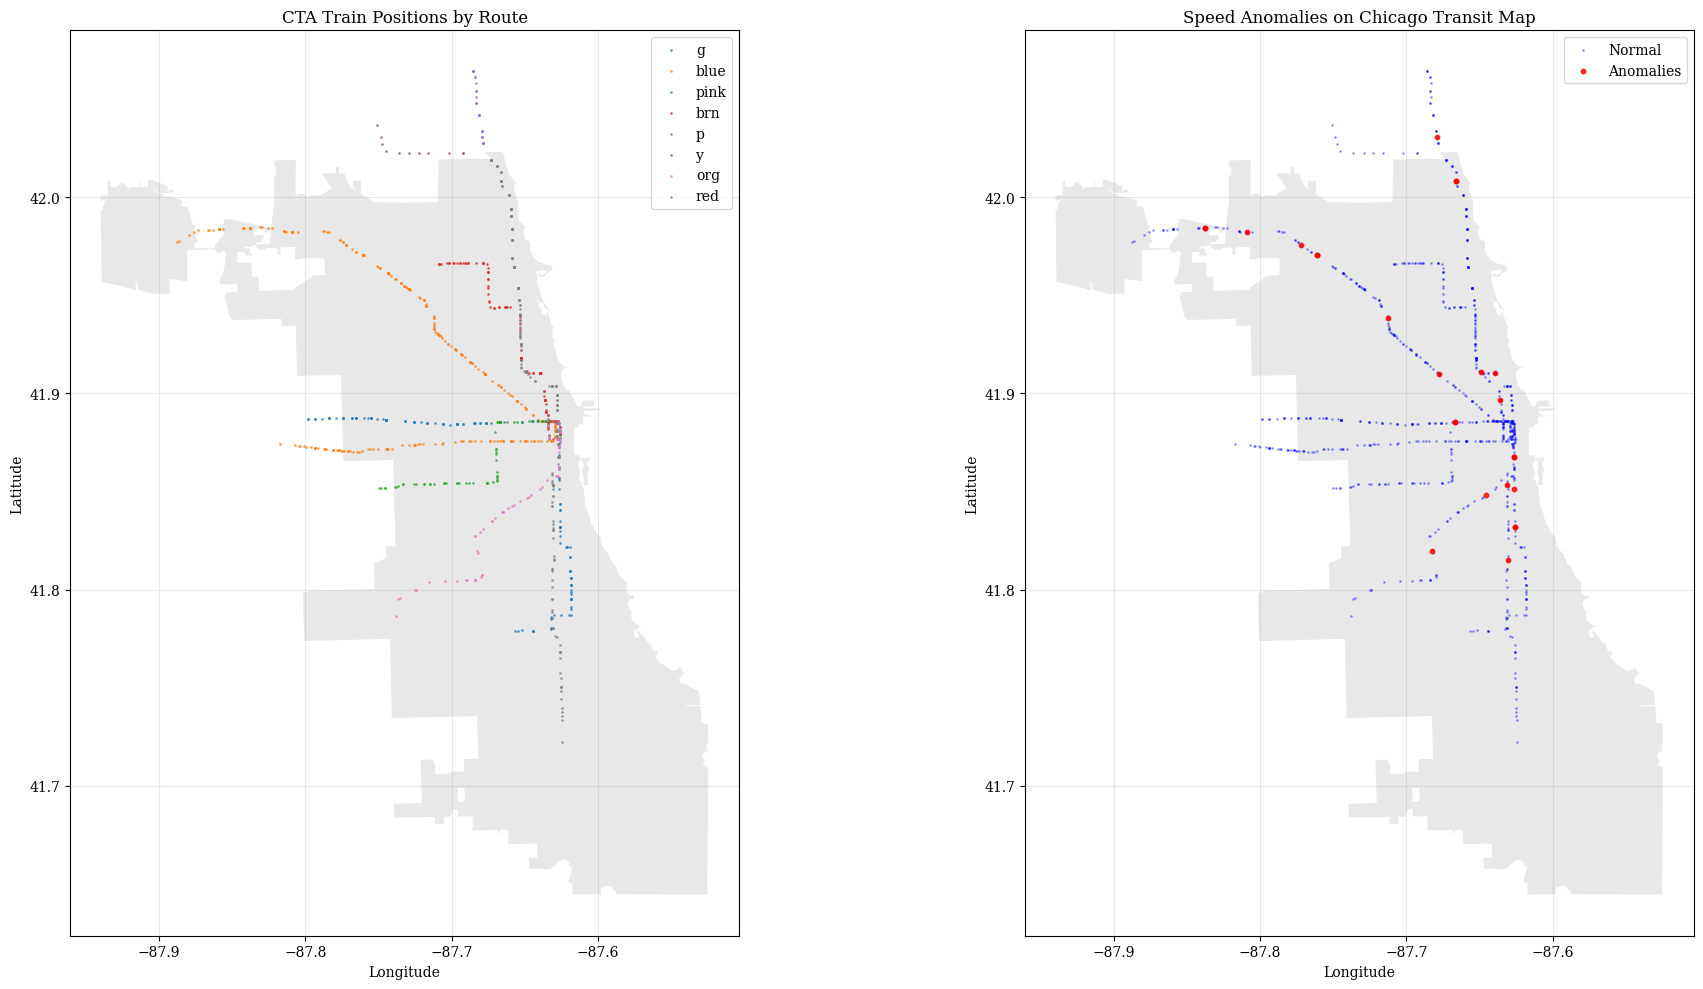


Example Speed Anomalies:
               datetime route_name run_number   speed_kmh  is_delayed
375 2025-09-01 18:57:49       blue        123  314.539540           0
669 2025-09-01 19:02:12       blue        206  281.138032           0
382 2025-09-01 18:57:49       blue        212  274.804928           0
516 2025-09-01 19:00:02       blue        116  268.469547           0
226 2025-09-01 18:55:44       blue        114  246.462582           0


In [15]:
# Create map visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: All train positions colored by route
chicago_map.plot(ax=axes[0], color='lightgray', alpha=0.5)
for route in df_sorted['route_name'].unique():
    route_data = df_sorted[df_sorted['route_name'] == route]
    axes[0].scatter(route_data['longitude'], route_data['latitude'], 
                   label=route, alpha=0.6, s=1)
axes[0].set_title('CTA Train Positions by Route')
axes[0].legend()
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot 2: Anomalies highlighted
chicago_map.plot(ax=axes[1], color='lightgray', alpha=0.5)
normal_data = df_sorted[~df_sorted['is_speed_anomaly']]
anomaly_data = df_sorted[df_sorted['is_speed_anomaly']]

axes[1].scatter(normal_data['longitude'], normal_data['latitude'], 
               c='blue', alpha=0.3, s=1, label='Normal')
axes[1].scatter(anomaly_data['longitude'], anomaly_data['latitude'], 
               c='red', alpha=0.8, s=10, label='Anomalies')
axes[1].set_title('Speed Anomalies on Chicago Transit Map')
axes[1].legend()
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

# Print some example anomalies
print("\nExample Speed Anomalies:")
anomaly_examples = df_sorted[df_sorted['is_speed_anomaly']].nlargest(5, 'speed_kmh')
print(anomaly_examples[['datetime', 'route_name', 'run_number', 'speed_kmh', 'is_delayed']].to_string())

## Key Observations & Next Steps

### Observations:
1. **Data Quality**: High-quality dataset with good coverage across all CTA lines
2. **Temporal Patterns**: Clear rush hour effects and route-specific behaviors
3. **Baseline Anomalies**: Z-score method identifies potential issues

### For Advanced Modeling:
1. **Feature Engineering**: Speed, time-based features, and spatial context
2. **Sequence Data**: Train trajectories for LSTM modeling
3. **Contextual Anomalies**: Route and time-specific baselines

### Model Candidates:
- **LightGBM**: For tabular anomaly detection
- **LSTM**: For sequence-based anomalies
- **Isolation Forest**: For unsupervised detection
- **Conformal Prediction**: For statistical confidence bounds